In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
from Channel_Generation_3 import Channel_Generation as GC


In [3]:
# Deciding the system parameters
# Tx Bandwidth is 100 MHz

K = 2     # No. of users
noise = -160 + 10 * np.log10(100 * 1e6)   # noise in dBm
print(noise)
ite = 1000                 #no of channel realisations
noise = 10 ** (noise/10 - 3) #linear scale
print(noise)
N = 150                      #no of elements in IRS
M = 4

-80.0
1e-11


In [4]:
#INITIALIZATION of POWER, BEAMFORMERS, PHASES

# Transmit power values to simulate 5dBm to 21 dBm
power_dBm = np.array(range(5, 21, 2))
#print(power_dBm)
P_mW = 10 ** (power_dBm/10) * 0.001
#print(P_mW)
P_range = len(P_mW)

# Initialize the beamforming matrix W randomly
W_1 =  np.random.rand(M,K) + 1j * np.random.rand(M,K)
W = np.zeros((M,K), dtype='complex')
W_ni = np.zeros((M,K), dtype='complex')
#for p in range(P_range):
for i in range(K):
  # When K users are served power is equally split among users
  W[:,i] = np.sqrt(1/K) * W_1[:,i] / np.linalg.norm(W_1[:,i])
  # When one user is served
  W_ni[:,i] = W_1[:,i] / np.linalg.norm(W_1[:,i])

# Initialising the phases at IRS
phase0 = np.random.rand(N)*2*np.pi
v = np.exp(1j*phase0)
Theta = np.diag(v)
print(Theta.shape)

(150, 150)


In [4]:
#GENERATE THE CHANNELS for each tx power value and each channel realization

Hr= np.zeros((P_range, ite, K, N), dtype= complex)
Hd= np.zeros((P_range, ite, K, M), dtype= complex)
G= np.zeros((P_range, ite, N, M), dtype= complex)
for p in range(P_range):
  for j in range(ite):
    CG= GC(K, M, N)
    Hd2, Hr2, G2= CG.Generate_Channels()
    Hd[p, j, :, :]= Hd2.T
    Hr[p, j, :, :]= Hr2.T
    G[p, j, :, :]= G2

In [5]:
#########################   STAGE 1 :  NO OPTIMIZATION   ###########################
# Compute the rates for each user for each tx power and each channel realization
# random initialization used for BF and RIS - W_1, W_ni, Theta

rate_1_stage1 = np.zeros((P_range,ite))
rate_2_stage1 = np.zeros((P_range,ite))
rate_1_NoInterference_stage1= np.zeros((P_range,ite))
rate_2_NoInterference_stage1= np.zeros((P_range,ite))

Ch_eq = np.zeros((P_range,ite,K,M), dtype='complex')
for p in range(P_range):
  for j in range(ite):
    for i in range(K):
      Ch_eq[p,j,i,:] = Hd[p,j,i,:] + (Hr[p,j,i,:].reshape(1, N) @ Theta @ G[p,j, :, :]).flatten()
      W[:,i] = np.sqrt(P_mW[p]/K) * W_1[:,i] / np.linalg.norm(W_1[:,i])

    # SINR and Rate of users before optimization

    rate_1_stage1[p,j]=(np.log2( 1 + (np.linalg.norm(Ch_eq[p,j,0,:] @ W[:,0]) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,0,:] @ W[:,1])**2 ))))
    #print('rate of user 1 with interference at  stage 1 :\n R1=', rate_1)

    rate_1_NoInterference_stage1[p,j]=(np.log2( 1 + (np.linalg.norm(Ch_eq[p,j,0,:] @ (np.sqrt(P_mW[p])*W_ni[:,0])) **2)/(noise)))
    #print('rate of user 1  No Interfence at  stage 1 :\n R1=', rate_1_NoInterference)


    rate_2_stage1[p,j]=(np.log2( 1 + (np.linalg.norm(Ch_eq[p,j,1,:] @ W[:,1]) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,1,:] @ W[:,0])**2 ))))
    #print('rate of user 2 with interference at stage 1 :\n R2=', rate_2)

    rate_2_NoInterference_stage1[p,j] =(np.log2( 1 + (np.linalg.norm(Ch_eq[p,j,1,:] @ (np.sqrt(P_mW[p])*W_ni[:,1])) **2)/(noise)))
    #print('rate of user 2 No interference at  stage 1 :\n R2=', rate_2_NoInterference)

avg_rate_1= np.mean(rate_1_stage1,axis=1)
print('avg.,rate of user 1 with interference at  stage 1 :\n R1=', avg_rate_1)
avg_rate_2= np.mean(rate_2_stage1,axis=1)

print('avg.,rate of user 2 with interference at  stage 1 :\n R2=', avg_rate_2)
avg_sum_rate1 = avg_rate_1 + avg_rate_2

avg_rate_no_interference_1= np.mean(rate_1_NoInterference_stage1,axis=1)
print('avg.,rate of user 1 without interference at  stage 1 :\n R1=', avg_rate_no_interference_1)
avg_rate_no_interference_2= np.mean(rate_2_NoInterference_stage1,axis=1)
print('avg.,rate of user 2 without interference at  stage 1 :\n R2=', avg_rate_no_interference_2)


avg.,rate of user 1 with interference at  stage 1 :
 R1= [0.03620991 0.05419344 0.07925504 0.11841029 0.16765464 0.24297005
 0.3378524  0.42569457]
avg.,rate of user 2 with interference at  stage 1 :
 R2= [0.43633809 0.54323591 0.63939268 0.74014246 0.83258702 0.91043164
 1.02332019 1.02942823]
avg.,rate of user 1 without interference at  stage 1 :
 R1= [0.07369095 0.11123667 0.16491217 0.25100094 0.36103839 0.53766189
 0.78263313 1.03142838]
avg.,rate of user 2 without interference at  stage 1 :
 R2= [1.07787015 1.4189811  1.75812009 2.21853477 2.72500672 3.25369211
 3.89333049 4.43612979]


In [6]:
################################ Stage 2 : Alternating Optimization ############################################### 

In [7]:

# Calculate the RIS phases that are optimal for user 1 alone (stored in theta1, phase2_AO1) for each tx power and channel realization
# case 1 : Theta Optimised for User 1:
iter = 0
iter_max= 6 # number of alternating opt iterations

rate1_iter_AO1 = np.zeros((P_range,ite, iter_max))
rate2_iter_AO1 = np.zeros((P_range,ite, iter_max))
theta1 = np.zeros((P_range,ite,N))
for p in range(P_range):
  for j in range(ite):
    W[:,0] = np.sqrt(P_mW[p]/K) * W_1[:,0] / np.linalg.norm(W_1[:,0])
    W[:,1] = np.sqrt(P_mW[p]/K) * W_1[:,1] / np.linalg.norm(W_1[:,1])
    for i in range(K-1):
        for iter in range(iter_max):
          #optimize the RIS phases for a given beamforming design
          theta= np.angle(Hd[p,j,0,:] @ W[:,0]) - np.angle((np.diag(Hr[p,j,0,:]) @ G[p,j,:,:] @ W[:,0]))
          v = np.exp(1j*theta)
          Theta = np.diag(v)
          Ch_eq[p,j,0,:] = Hr[p,j,0,:] @ Theta @ G[p,j,:,:] + Hd[p,j,0,:]
          Ch_eq[p,j,1,:] = Hr[p,j,1,:] @ Theta @ G[p,j,:,:] + Hd[p,j,1,:]


          # Updating W for user 1
          W[:,0] = np.sqrt(P_mW[p]/K) * np.conj(Ch_eq[p,j,0,:]).T / np.linalg.norm(Ch_eq[p,j,0,:])  #MRT equation

          # SINR and Rate after update
          rate1_iter_AO1[p,j,iter]= (np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,0,:] @ W[:,0])) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,0,:]@ W[:,1])**2))))
          rate2_iter_AO1[p,j,iter]= (np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,1,:] @ W[:,1])) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,1,:]@ W[:,0])**2))))
          #print(rate1_iter_o1[j])

          iter += 1
    theta1[p,j,:] = theta
            

rate1_stage2_AO1= np.mean(rate1_iter_AO1[:,:,5], axis=1)
rate2_stage2_AO1= np.mean(rate2_iter_AO1[:,:,5], axis=1)

print('Avg. Rate of User 1 AO1 at stage 2:\n R1= ',rate1_stage2_AO1)
print('Avg. Rate of User 2 AO1 at stage 2:\n R2= ',rate2_stage2_AO1)

phase2_AO1 = theta1    # we get updated 'theta' values at stage 2 (case 1).
#print('phase\n',phase2_AO1)

Avg. Rate of User 1 AO1 at stage 2:
 R1=  [0.93610152 1.21238183 1.50790011 1.80343392 2.06384004 2.31027669
 2.50025866 2.61097823]
Avg. Rate of User 2 AO1 at stage 2:
 R2=  [0.48200992 0.6042203  0.68402013 0.81305557 0.93865585 1.04261731
 1.12141904 1.18557234]


In [8]:
print(rate1_stage2_AO1+rate2_stage2_AO1)

[1.41811144 1.81660213 2.19192025 2.61648948 3.00249589 3.352894
 3.62167769 3.79655056]


In [9]:
# Calculate the RIS phases that are optimal for user 2 alone (stored in theta2, phase2_AO2) for each tx power and channel realization
# Case 2 : theta optimised for User 2 :
iter = 0
iter_max=6
rate1_iter_AO2 = np.zeros((P_range,ite, iter_max))
rate2_iter_AO2 = np.zeros((P_range,ite, iter_max))
theta2 = np.zeros((P_range,ite,N))

for p in range(P_range):
  for j in range(ite):
    W[:,0] = np.sqrt(P_mW[p]/K) * W_1[:,0] / np.linalg.norm(W_1[:,0])
    W[:,1] = np.sqrt(P_mW[p]/K) * W_1[:,1] / np.linalg.norm(W_1[:,1])
    for i in range(K):
        i += 1
        for iter in range(iter_max):
          #optimize the RIS phases for a given beamforming design
          theta= np.angle(Hd[p,j,1,:] @ W[:,1]) - np.angle((np.diag(Hr[p,j,1,:]) @ G[p,j,:,:] @ W[:,1]))
          v = np.exp(1j*theta)
          Theta = np.diag(v)
          Ch_eq[p,j,1,:] = Hr[p,j,1,:] @ Theta @ G[p,j,:,:] + Hd[p,j,1,:]
          Ch_eq[p,j,0,:] = Hr[p,j,0,:] @ Theta @ G[p,j,:,:] + Hd[p,j,0,:]

          # Updating W for user 2
          W[:,1] = np.sqrt(P_mW[p]/K) * np.conj(Ch_eq[p,j,1,:]).T / np.linalg.norm(Ch_eq[p,j,1,:])  #MRT equation

          # SINR and Rate after update
          rate1_iter_AO2[p,j,iter]=(np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,0,:] @ W[:,0])) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,0,:]@ W[:,1])**2))))
          rate2_iter_AO2[p,j,iter]=(np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,1,:] @ W[:,1])) **2)/(noise + (np.linalg.norm(Ch_eq[p,j,1,:]@ W[:,0])**2))))
          iter += 1
    theta2[p,j,:] = theta      

rate1_stage2_AO2 = np.mean(rate1_iter_AO2[:,:,5], axis=1)
rate2_stage2_AO2 = np.mean(rate2_iter_AO2[:,:,5], axis=1)
print('Avg. Rate for User 1 AO2 at stage 2:\n R1= ',rate1_stage2_AO2)
print('Avg. Rate for User 2 AO2 at stage 2:\n R2= ',rate2_stage2_AO2)

phase2_AO2 = theta2       # we get updated 'theta' values at stage 2 (case2).
#print(phase2_AO2)


Avg. Rate for User 1 AO2 at stage 2:
 R1=  [0.0364427  0.05611978 0.08124422 0.12145441 0.17343542 0.25714756
 0.35745795 0.44910911]
Avg. Rate for User 2 AO2 at stage 2:
 R2=  [1.78090289 2.06829512 2.40567643 2.60856077 2.79801009 2.99449603
 3.10342064 3.17105552]


In [10]:
print(rate1_stage2_AO2+ rate2_stage2_AO2)

[1.81734558 2.12441489 2.48692065 2.73001518 2.9714455  3.25164359
 3.46087859 3.62016463]


In [11]:
# calculate the rates for each user if only that user is served with full tx power
# Case 3 : Single User is served only (No Interference):
rate1_iter_NI = np.zeros((P_range,ite,iter_max))
rate2_iter_NI = np.zeros((P_range,ite,iter_max))

for p in range(P_range):
  for j in range(ite):
    W_ni[:,0] = np.sqrt(P_mW[p]) * W_1[:,0] / np.linalg.norm(W_1[:,0])
    W_ni[:,1] = np.sqrt(P_mW[p]) * W_1[:,1] / np.linalg.norm(W_1[:,1])
    for i in range(K):
        iter = 0
        error = 1000
        for iter in range(iter_max):

          #optimize the RIS phases for a given beamforming design
          theta= np.angle(Hd[p,j,i,:] @ W_ni[:,i]) - np.angle((np.diag(Hr[p,j,i,:]) @ G[p,j,:,:] @ W_ni[:,i]))
          v = np.exp(1j*theta)
          Theta = np.diag(v)
          Ch_eq[p,j,i,:] = Hr[p,j,i,:] @ Theta @ G[p,j,:,:] + Hd[p,j,i,:]

          # Updating W for user i
          W_ni[:,i] = np.sqrt(P_mW[p]) * np.conj(Ch_eq[p,j,i,:]).T / np.linalg.norm(Ch_eq[p,j,i,:])

          # SINR and Rate after update
          rate1_iter_NI[p,j,iter] = (np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,0,:] @ W_ni[:,0])) **2)/(noise)))
          rate2_iter_NI[p,j,iter] = (np.log2( 1 + ((np.linalg.norm(Ch_eq[p,j,1,:] @ W_ni[:,1])) **2)/(noise)))
          #while iter < iter_max:
          iter += 1

rate1_stage2_NI = np.mean(rate1_iter_NI[:,:,5], axis=1)
rate2_stage2_NI = np.mean(rate2_iter_NI[:,:,5], axis=1)
#print('\n')
#print('Rate for User 1 no interference at stage 2:\n R1= ',rate1_stage2_NI)
#print('Rate for User 2 no interference at stage 2:\n R2= ',rate2_stage2_NI)
#plt.plot( power_dBm, rate1_stage2_NI, marker='o', label= 'User 1 AO NI')
#plt.plot(power_dBm, rate2_stage2_NI, marker= 'v', label= 'User 2 AO NI')

In [12]:
print('Rate for User 1 no interference at stage 2:\n R1= ',rate1_stage2_NI)
print('Rate for User 2 no interference at stage 2:\n R2= ',rate2_stage2_NI)

Rate for User 1 no interference at stage 2:
 R1=  [1.66365044 2.14359812 2.67669016 3.26727799 3.87993079 4.50472481
 5.15521238 5.78367077]
Rate for User 2 no interference at stage 2:
 R2=  [3.11631442 3.68351386 4.34006097 4.9435073  5.60647173 6.26896227
 6.92808289 7.5681305 ]


In [13]:
#########################   STAGE 3 : Zero Forcing  ################################

In [14]:
# # Code for waterfilling power allocation to users 
# def water_fill_8users_2(K, P_dBm, gain):
#     s_lst = np.zeros(K)     #store the norm of each column of precoder
#     g_lst = np.zeros(K)     #store the inverse of SNR for each channel
#     P_k = np.zeros(K)       #store the allocated power for each user
#     nu = np.zeros(K)        #store the threshold
#     nu_opt = 0
#     sum = 0
#     P = 10 ** (P_dBm/10 - 3)



#     #print('Power(W)=',P )
#     for i in range(K):
#         s_lst[i] = gain[i]**2
#         g_lst[i] = noise * s_lst[i]
#         sum = sum + g_lst[i]
#         nu[i] = (P + sum)/(i+1)
#     #print('g_lst=',g_lst)


#     threshold_achieved = False  #threshold is not achieved
#     for i in range(K-1):
#         if ((nu[i] - g_lst[i+1])<0):
#             nu_opt = nu[i]
#             threshold_achieved = True #threshold is achieved
#             P_k[i] = nu_opt - g_lst[i]
#             break

#     if threshold_achieved==False:  #if threshold is not achieved 
#         nu_opt = nu[K-1]
#     #print('nu_opt=',nu_opt)

#     for i in range(K):
#         temp = nu_opt - g_lst[i]
#         P_k[i]= temp if temp>=0 else 0
              

#     #print('P_k=',P_k)
#     #print('sum of all P_k=',np.sum(P_k))
#     #print('nu =',nu)
       
#     return P_k

# P_user = np.zeros((P_range,K))


In [15]:
# # Rates for ZFBF with phase optimized for user 1

# # Case 1 : theta optimised for User 1  : 
# rate1_iter_AO1zf = np.zeros((P_range,ite))
# rate2_iter_AO1zf = np.zeros((P_range,ite))
# for p in range(P_range):
#   for j in range(ite):
#     v = np.exp(1j*phase2_AO1[p,j,:])
#     Theta = np.diag(v)
#     Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
#     for i in range(K):
#       #for iter in range(iter_max):
       
#         Ch_eq1 = Ch_eq[p,j,0,:]
#         Ch_eq2 = Ch_eq[p,j,1,:]

#         # Optimising the W
        
#         W = np.linalg.pinv(Ch_eq[p,j,:,:])

#         #importing codes from waterfilling:
#         wk = np.linalg.norm(W, axis = 0)
#         wk = np.sort(wk)
#         #print('wk=',wk.shape)
#         P_user[p] = water_fill_8users_2(K,power_dBm[p],wk)
#         # Extracting W2 from W
#         print("P_user",P_user[p])
#         print("P_mW",P_mW[p])

#         W2 = (W[:,1]/wk[1])*np.sqrt(P_user[p,1])
#         W1 = (W[:,0]/wk[0])*np.sqrt(P_user[p,0])


#         # SINR and Rate after update

#         rate1_iter_AO1zf[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1)) **2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))
#         rate2_iter_AO1zf[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/ (noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))

# rate1_stage3_AO1 = np.mean(rate1_iter_AO1zf,axis=1)
# rate2_stage3_AO1 = np.mean(rate2_iter_AO1zf,axis=1)
# print('Avg. rate for User 1 AO1 @ stage 3:\n R1 = ',rate1_stage3_AO1)
# print('Avg. rate for User 2 AO1 @ stage 3:\n R2 = ',rate2_stage3_AO1)
# plt.plot(power_dBm, rate1_stage3_AO1, marker='o', label= 'R1, User 1 served, ZF')
# plt.plot(power_dBm, rate2_stage3_AO1, marker= 'v', label= 'R2, User 1 served, ZF')
# plt.grid()
# plt.legend()
# plt.show()


In [16]:
# # Rates for ZFBF with phase optimized for user 2

# # Case 2 : Phase optimised for User 2 :
# #iter_max=6
# #phase2_AO2 = phase2_AO2/np.linalg.norm(phase2_AO2)
# rate1_iter_AO2zf = np.zeros((P_range,ite))
# rate2_iter_AO2zf = np.zeros((P_range,ite))

# for p in range(P_range):
#   for j in range(ite):
#     v = np.exp(1j*phase2_AO2[p,j,:])
#     Theta = np.diag(v)
#     Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
#     for i in range(K):
#       for iter in range(iter_max):

#         Ch_eq1 = Ch_eq[p,j,0,:]
#         Ch_eq2 = Ch_eq[p,j,1,:]

#         #Optimising the W
#         W = np.linalg.pinv(Ch_eq[p,j,:,:])

#          #importing codes from waterfilling:
#         #wk = np.linalg.norm(W, axis = 0)
#         #wk = np.sort(wk)
#         # print('wk=',(wk.shape))
#         #P_user[p] = water_fill_8users_2(K,power_dBm[p],wk)
#        # print(P_user[:,:])
#         # Extracting W2 from W
#         W2 = W[:,1]/np.linalg.norm(W[:,1])*np.sqrt(P_mW[p]/K)
#         W1 = W[:,0]/np.linalg.norm(W[:,0])*np.sqrt(P_mW[p]/K)
#         #print('W2=', W2)

#         # SINR and Rate after update
#         rate2_iter_AO2zf[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/(noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))
#         rate1_iter_AO2zf[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1))**2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))

# rate1_stage3_AO2 = np.mean(rate1_iter_AO2zf,axis=1)
# rate2_stage3_AO2 = np.mean(rate2_iter_AO2zf,axis=1)
# print('rate for User 1 AO2 stage 3:\n R1 = ',rate1_stage3_AO2)
# print('rate for User 2 AO2 stage 3:\n R2 = ',rate2_stage3_AO2)


In [17]:
# plt.plot(power_dBm, rate1_stage3_AO2, marker='o', label= 'R1,User 2 served, ZF')
# plt.plot(power_dBm, rate2_stage3_AO2, marker= 'v', label= 'R2,User 2 served, ZF')
# plt.legend()
# plt.grid()
# plt.show()

In [18]:
# # Case 3 : Random Phase + ZF Beam-Forming :
# rate1_iter_NI = np.zeros((P_range,ite))
# rate2_iter_NI = np.zeros((P_range,ite))
# #iter_max = 6
# phase_rnd = np.random.rand((N))*2*np.pi

# for p in range(P_range):
#   for j in range(ite):
#     for i in range(K):
#       #for iter in range(iter_max):
#         v = np.exp(1j* phase_rnd)
#         Theta = np.diag(v)

#         Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
#         Ch_eq1 = Ch_eq[p,j,0,:]
#         Ch_eq2 = Ch_eq[p,j,1,:]


#         # Optimising the W
#         W = np.linalg.pinv(Ch_eq[p,j,:,:])
#         #print('zeroforcing check:\n', Ch_eq @ W)

#         #importing Waterfilling into ZF
#         wk = np.linalg.norm(W, axis=0)
#         wk = np.sort(wk)

#         P_user[p] = water_fill_8users_2(K,power_dBm[p],wk)

#         # Extracting W2 from W
#         W2 = W[:,1]/wk[1] * np.sqrt(P_user[p,1])
#         W1 = W[:,0]/wk[0] * np.sqrt(P_user[p,0])

#         # Rate after update
#         rate1_iter_NI[p,j] = (np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1))**2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))
#         rate2_iter_NI[p,j] = (np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/(noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))

# rate1_stage3_Rnd = np.mean(rate1_iter_NI,axis=1)
# rate2_stage3_Rnd = np.mean(rate2_iter_NI,axis=1)

# print('rate for User 1 @ stage 3:\n R1 = ',rate1_stage3_Rnd)
# print('rate for User 2 @ stage 3:\n R2 = ',rate2_stage3_Rnd)

# SR_U1 = rate1_stage3_AO1 + rate2_stage3_AO1
# SR_U2 = rate1_stage3_AO2 + rate2_stage3_AO2
# SR_NI = rate1_stage3_Rnd + rate2_stage3_Rnd
# print('Sum Rate case 1:',SR_U1)
# print('Sum Rate case 2:',SR_U2)
# print('Sum Rate case 3:',SR_NI)



In [19]:
#########################   STAGE 3 : Zero Forcing No Waterfilling ################################

Avg. rate for User 1 AO1 @ stage 3:
 R1 =  [0.85936546 1.1769262  1.57073978 2.02904228 2.57348752 3.15057135
 3.72633496 4.35090323]
Avg. rate for User 2 AO1 @ stage 3:
 R2 =  [1.50464568 1.91151978 2.43883218 2.91617434 3.54741709 4.18913846
 4.78156847 5.42591057]


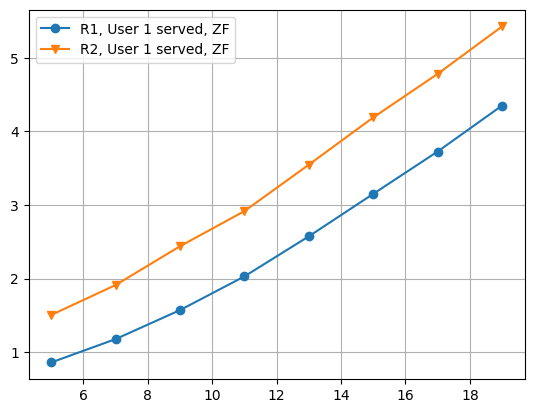

In [20]:
# Case 1 : theta optimised for User 1  : 
#iter_max = 6
rate1_iter_AO1zf_2 = np.zeros((P_range,ite))
rate2_iter_AO1zf_2 = np.zeros((P_range,ite))
for p in range(P_range):
  for j in range(ite):
    v = np.exp(1j*phase2_AO1[p,j,:])
    Theta = np.diag(v)
    Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
    for i in range(K):
      #for iter in range(iter_max):
       
        Ch_eq1 = Ch_eq[p,j,0,:]
        Ch_eq2 = Ch_eq[p,j,1,:]

        # Optimising the W
        
        W = np.linalg.pinv(Ch_eq[p,j,:,:])

       
        # Extracting W2 from W
        W2 = (W[:,1]/np.linalg.norm(W[:,1]))*np.sqrt(P_mW[p]/K)
        W1 = (W[:,0]/np.linalg.norm(W[:,0]))*np.sqrt(P_mW[p]/K)

        # SINR and Rate after update

        rate1_iter_AO1zf_2[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1)) **2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))
        rate2_iter_AO1zf_2[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/ (noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))

rate1_stage3_AO1_2 = np.mean(rate1_iter_AO1zf_2,axis=1)
rate2_stage3_AO1_2 = np.mean(rate2_iter_AO1zf_2,axis=1)
print('Avg. rate for User 1 AO1 @ stage 3:\n R1 = ',rate1_stage3_AO1_2)
print('Avg. rate for User 2 AO1 @ stage 3:\n R2 = ',rate2_stage3_AO1_2)
plt.plot(power_dBm, rate1_stage3_AO1_2, marker='o', label= 'R1, User 1 served, ZF')
plt.plot(power_dBm, rate2_stage3_AO1_2, marker= 'v', label= 'R2, User 1 served, ZF')
plt.grid()
plt.legend()
plt.show()


rate for User 1 AO2 stage 3:
 R1 =  [0.10921294 0.16685235 0.24964172 0.37694525 0.55622511 0.80210875
 1.11216809 1.45445442]
rate for User 2 AO2 stage 3:
 R2 =  [1.93982937 2.40688129 2.99749315 3.5407601  4.2022029  4.8307042
 5.44904336 6.07220048]


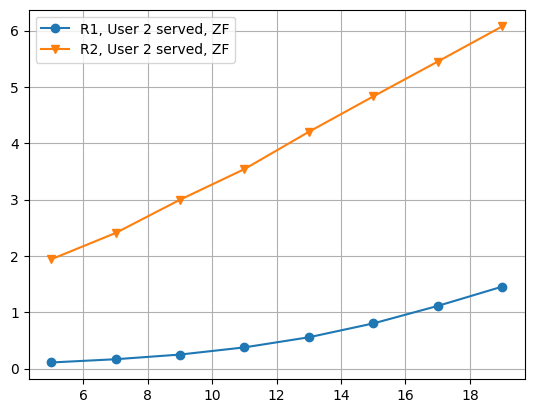

In [21]:
# Case 2 : Phase optimised for User 2 :
#iter_max=6
#phase2_AO2 = phase2_AO2/np.linalg.norm(phase2_AO2)
rate1_iter_AO2zf_2 = np.zeros((P_range,ite))
rate2_iter_AO2zf_2 = np.zeros((P_range,ite))

for p in range(P_range):
  for j in range(ite):
    v = np.exp(1j*phase2_AO2[p,j,:])
    Theta = np.diag(v)
    Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
    for i in range(K):
      for iter in range(iter_max):

        Ch_eq1 = Ch_eq[p,j,0,:]
        Ch_eq2 = Ch_eq[p,j,1,:]

        #Optimising the W
        W = np.linalg.pinv(Ch_eq[p,j,:,:])
        #print('zeroforcing check:\n', Ch_eq @ W) 
        # Extracting W2 from W
        W2 = (W[:,1]/np.linalg.norm(W[:,1]))*np.sqrt(P_mW[p]/K)
        W1 = (W[:,0]/np.linalg.norm(W[:,0]))*np.sqrt(P_mW[p]/K)
        #print('W2=', W2)

        # SINR and Rate after update
        rate2_iter_AO2zf_2[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/(noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))
        rate1_iter_AO2zf_2[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1))**2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))

rate1_stage3_AO2_2 = np.mean(rate1_iter_AO2zf_2,axis=1)
rate2_stage3_AO2_2 = np.mean(rate2_iter_AO2zf_2,axis=1)
print('rate for User 1 AO2 stage 3:\n R1 = ',rate1_stage3_AO2_2)
print('rate for User 2 AO2 stage 3:\n R2 = ',rate2_stage3_AO2_2)
plt.plot(power_dBm, rate1_stage3_AO2_2, marker='o', label= 'R1, User 2 served, ZF')
plt.plot(power_dBm, rate2_stage3_AO2_2, marker= 'v', label= 'R2, User 2 served, ZF')
plt.grid()
plt.legend()
plt.show()

In [22]:
# Case 3 : Random Phase + ZF Beam-Forming :
rate1_iter_NI_2 = np.zeros((P_range,ite))
rate2_iter_NI_2 = np.zeros((P_range,ite))
#iter_max = 6
phase_rnd = np.random.rand((N))*2*np.pi

for p in range(P_range):
  for j in range(ite):
    for i in range(K):
      #for iter in range(iter_max):
        v = np.exp(1j* phase_rnd)
        Theta = np.diag(v)

        Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta @ G[p,j,:,:] + Hd[p,j,:,:]
        Ch_eq1 = Ch_eq[p,j,0,:]
        Ch_eq2 = Ch_eq[p,j,1,:]


        # Optimising the W
        W = np.linalg.pinv(Ch_eq[p,j,:,:])
        #print('zeroforcing check:\n', Ch_eq @ W)
        # Extracting W2 from W
        W2 = W[:,1]/np.linalg.norm(W[:,1])*np.sqrt(P_mW[p]/K)
        W1 = W[:,0]/np.linalg.norm(W[:,0])*np.sqrt(P_mW[p]/K)

        # Rate after update
        rate1_iter_NI_2[p,j] = (np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1))**2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))
        rate2_iter_NI_2[p,j] = (np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/(noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))

rate1_stage3_Rnd_2 = np.mean(rate1_iter_NI_2,axis=1)
rate2_stage3_Rnd_2 = np.mean(rate2_iter_NI_2,axis=1)

print('rate for User 1 @ stage 3:\n R1 = ',rate1_stage3_Rnd_2)
print('rate for User 2 @ stage 3:\n R2 = ',rate2_stage3_Rnd_2)

SR_U1_2 = rate1_stage3_AO1_2 + rate2_stage3_AO1_2
SR_U2_2 = rate1_stage3_AO2_2 + rate2_stage3_AO2_2
SR_NI_2 = rate1_stage3_Rnd_2 + rate2_stage3_Rnd_2
print('Sum Rate case 1:',SR_U1_2)
print('Sum Rate case 2:',SR_U2_2)
print('Sum Rate case 3:',SR_NI_2)



rate for User 1 @ stage 3:
 R1 =  [0.11237222 0.16790474 0.25649401 0.3854091  0.56600921 0.81824571
 1.13315928 1.48170174]
rate for User 2 @ stage 3:
 R2 =  [1.4935681  1.91018956 2.45067681 2.93828949 3.57478359 4.20613849
 4.8223528  5.42248623]
Sum Rate case 1: [2.36401114 3.08844599 4.00957196 4.94521662 6.12090461 7.33970981
 8.50790343 9.7768138 ]
Sum Rate case 2: [2.04904232 2.57373364 3.24713487 3.91770536 4.75842802 5.63281295
 6.56121145 7.5266549 ]
Sum Rate case 3: [1.60594032 2.0780943  2.70717083 3.3236986  4.1407928  5.0243842
 5.95551208 6.90418797]


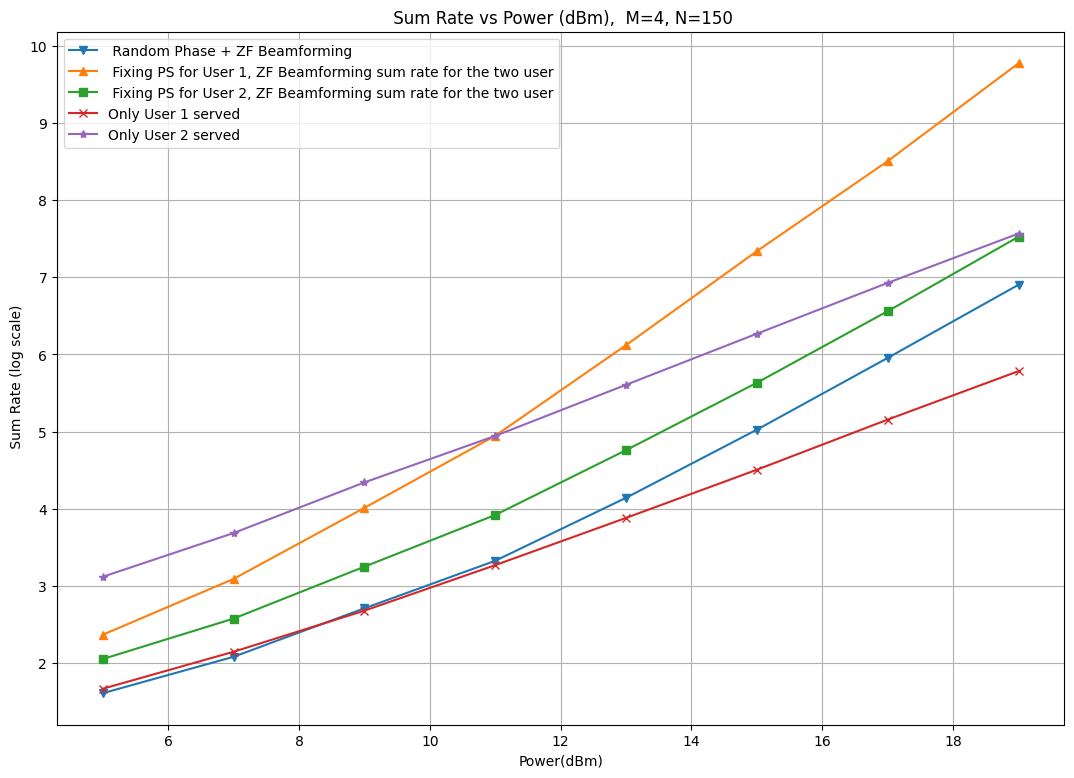

In [23]:
#this plot
plt.figure(figsize=(13,9))
# 1. Avg Sum Rate for RP + Rnd BF
#plt.plot(power_dBm,avg_sum_rate1, marker='o', label='1. Avg Sum Rate for RP + Rnd BF')

# 2. Avg Sum Rate for RP + ZF BF
plt.plot(power_dBm,SR_NI_2, marker='v',label=' Random Phase + ZF Beamforming')

# 3. Avg Sum Rate for Ph Opt for User 1 + ZF BF
plt.plot(power_dBm, SR_U1_2, marker='^', label=' Fixing PS for User 1, ZF Beamforming sum rate for the two user')

# 4. Avg Sum Rate for Ph Opt for User 2 + ZF BF
plt.plot(power_dBm, SR_U2_2, marker='s', label=' Fixing PS for User 2, ZF Beamforming sum rate for the two user')

# 5. Avg  Rate Only User 1 is served
plt.plot(power_dBm, rate1_stage2_NI, marker='x', label='Only User 1 served')

# 6. Avg Rate Only User 2 is served
plt.plot(power_dBm, rate2_stage2_NI, marker='*', label='Only User 2 served')

plt.title(f' Sum Rate vs Power (dBm),  M={M}, N={N}')
plt.xlabel('Power(dBm)')
plt.ylabel(' Sum Rate (log scale)')
plt.grid(True)
plt.legend()
plt.show()


In [24]:
# print(theta1[0,0,:])
# print(theta2[0,0,:])

SPLITTING OF IRS ELEMENTS INTO 2 PARTS WITH PHASE SHIFTS OPTIMISED FOR 2 USERS 

In [25]:
theta3 = np.zeros((P_range, ite, N))
theta_2 = np.concatenate((theta1[:,:,:75], theta2[:,:,75:]), axis=2)
#theta_2 = np.concatenate((theta1[:,:,:75], theta3[:,:,75:]), axis=2)
print(theta_2[0,0,:])
#print(theta_2[0,0,:]) # post split new phase-shift is generated for each tx power & channel realization


[ 2.18005725 -1.60684956  1.95720247 -1.24180217  1.79083329 -0.70495931
  2.62826181 -0.87555455  2.35163384 -0.89984364  1.72852424 -1.27706897
  2.93580304 -1.21515646  1.89557083 -1.20889705  2.56045065  0.0739969
  2.2987036  -0.44198042  2.07516243 -2.37573491  2.55427039 -0.44641477
  2.76775151 -1.01710592  2.32504338 -0.66053704  2.73321631 -0.79916585
  2.09312464 -0.67221079  1.08240842 -1.12426262  2.0836195  -0.75265572
  1.6875728  -1.23595739  2.47235988 -0.38512905  2.53967708 -1.30387068
  2.32858948 -1.75847772  2.10156638 -1.38724123  1.97212361 -0.46992894
  2.02019067 -0.87080077  2.54298035 -0.62169315  2.71559714 -1.55940784
  2.02818303 -0.50164122  2.12359541 -0.76179937  2.01858345 -0.80912753
  1.5087288  -1.3639185   2.57611812 -0.79743319  2.0403011  -1.22991692
  2.84836236 -0.74859016  2.04361352 -1.17961785  1.84991032 -1.33251077
  2.51622443 -0.92145906  2.6635465  -1.14888587 -1.79922513 -2.80078298
 -2.47877719 -3.13140947  0.81000586  0.80508949 -0.

ZF BEAMFORMING USING SPLIT IRS

In [26]:

rate1_zf_split = np.zeros((P_range,ite))
rate2_zf_split = np.zeros((P_range,ite))

for p in range(P_range):
  for j in range(ite):
    v2 = np.exp(1j*theta_2[p,j,:])

    Theta2 = np.diag(v2)

    Ch_eq[p,j,:,:] = Hr[p,j,:,:] @ Theta2 @ G[p,j,:,:] + Hd[p,j,:,:]
    for i in range(K):
      for iter in range(iter_max):

        Ch_eq1 = Ch_eq[p,j,0,:]
        Ch_eq2 = Ch_eq[p,j,1,:]

        #Optimising the W
        W = np.linalg.pinv(Ch_eq[p,j,:,:])

        W2 = (W[:,1]/np.linalg.norm(W[:,1]))*np.sqrt(P_mW[p]/K)
        W1 = (W[:,0]/np.linalg.norm(W[:,0]))*np.sqrt(P_mW[p]/K)

        # SINR and Rate after update
        rate2_zf_split[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq2 @ W2)) **2)/(noise + (np.linalg.norm(Ch_eq2 @ W1))**2)))
        rate1_zf_split[p,j]=(np.log2( 1 + ((np.linalg.norm(Ch_eq1 @ W1))**2)/ (noise + (np.linalg.norm(Ch_eq1 @ W2))**2)))

rate1_split = np.mean(rate1_zf_split,axis=1)
rate2_split = np.mean(rate2_zf_split,axis=1)
print('rate for User 1 :\n R1 = ',rate1_split)
print('rate for User 2 :\n R2 = ',rate2_split)
print('sum rate zf irs split=',rate1_split + rate2_split)


rate for User 1 :
 R1 =  [0.34365852 0.50043785 0.71180161 0.99640742 1.38828391 1.82864483
 2.30338667 2.83199872]
rate for User 2 :
 R2 =  [1.56945524 1.9834921  2.50885523 2.99772456 3.64588458 4.28677744
 4.87201691 5.51351063]
sum rate zf irs split= [1.91311376 2.48392995 3.22065684 3.99413197 5.03416849 6.11542227
 7.17540358 8.34550935]


In [27]:
SR_U3 = rate1_split + rate2_split
print('split irs=',SR_U3)
print('user2=',SR_U2_2)
print('user1=',SR_U1_2)

split irs= [1.91311376 2.48392995 3.22065684 3.99413197 5.03416849 6.11542227
 7.17540358 8.34550935]
user2= [2.04904232 2.57373364 3.24713487 3.91770536 4.75842802 5.63281295
 6.56121145 7.5266549 ]
user1= [2.36401114 3.08844599 4.00957196 4.94521662 6.12090461 7.33970981
 8.50790343 9.7768138 ]


In [28]:
# #this plot
# plt.figure(figsize=(13,9))
# plt.plot(power_dBm, SR_U1_2, marker='^', label='Fixing PS for User 1, ZF Beamforming for the two user')
# plt.plot(power_dBm, SR_U2_2, marker='s', label='Fixing PS for User 2, ZF Beamforming for the two user')


# plt.plot(power_dBm,SR_NI_2, marker='v',label=' Rand0m Phase + ZF Beamforming')
# plt.plot(power_dBm, rate1_stage2_NI, marker='x', label='Only User 1 served')
# plt.plot(power_dBm, rate2_stage2_NI, marker='*', label='Only User 2 served')


# plt.plot(power_dBm,SR_U3, label='Split IRS' )
# plt.title(f'  Sum Rate vs Power (dBm), M={M},N={N}')
# plt.xlabel('Power(dBm)')
# plt.ylabel(' Sum Rate (log scale)')
# plt.grid(True)
# plt.legend()
# plt.show()


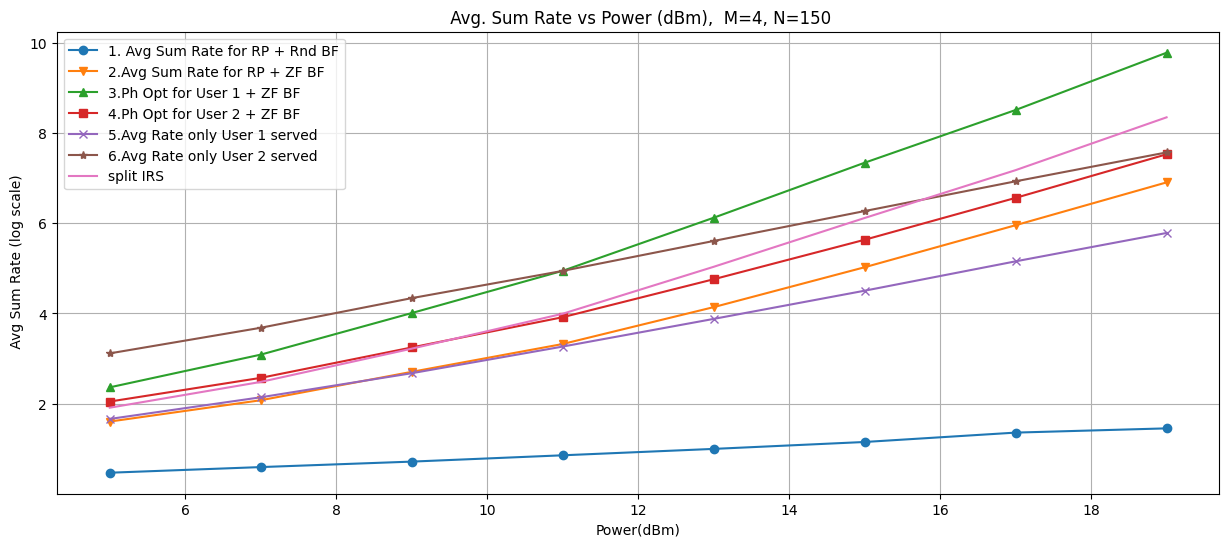

In [29]:
plt.figure(figsize=(15,6))
# 1. Avg Sum Rate for RP + Rnd BF
plt.plot(power_dBm,avg_sum_rate1, marker='o', label='1. Avg Sum Rate for RP + Rnd BF')

# 2. Avg Sum Rate for RP + ZF BF
plt.plot(power_dBm,SR_NI_2, marker='v',label='2.Avg Sum Rate for RP + ZF BF')

# 3. Avg Sum Rate for Ph Opt for User 1 + ZF BF
plt.plot(power_dBm, SR_U1_2, marker='^', label='3.Ph Opt for User 1 + ZF BF')

# 4. Avg Sum Rate for Ph Opt for User 2 + ZF BF
plt.plot(power_dBm, SR_U2_2, marker='s', label='4.Ph Opt for User 2 + ZF BF')

# 5. Avg  Rate Only User 1 is served
plt.plot(power_dBm, rate1_stage2_NI, marker='x', label='5.Avg Rate only User 1 served')

# 6. Avg Rate Only User 2 is served
plt.plot(power_dBm, rate2_stage2_NI, marker='*', label='6.Avg Rate only User 2 served')

#7 split irs
plt.plot(power_dBm,SR_U3, label='split IRS' )

plt.title(f' Avg. Sum Rate vs Power (dBm),  M={M}, N={N}')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (log scale)')
plt.grid(True)
plt.legend()
plt.show()
